## Check the gas cube in FIRE simulation

In [3]:
# import packages
from astropy.utils import data
from radio_beam import Beam
from astropy import units as u
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
from scipy.stats.stats import pearsonr
from matplotlib import rcParams
rcParams['mathtext.default']='regular'
import seaborn as sns
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import functions
def count_time(stop, start):
    '''
    Convert the time difference into human readable form. 
    '''
    dure=stop-start
    m,s=divmod(dure,60)
    h,m=divmod(m,60)
    print("%d:%02d:%02d" %(h, m, s))

    return

#### Load the gas cube

In [1]:
npzDir = '../FIRE_GalSep/'
fitsDir = '../data/e2/'
logDir = '../data/'

Load the G2&G3 information to select which cube to be used

[ 54.  55.  56. 540. 541. 542. 546. 553. 557. 579. 580. 586.]


array([2.5917])

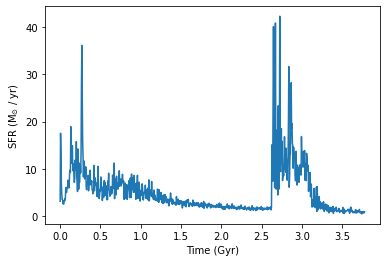

In [49]:
filename=npzDir+'galsep_G2G3_e_orbit_2.npz'

data = np.load(filename)
SFRs = data['sfr']
Times = data['time']
Snapshots = data['isnap']

fig = plt.figure()
plt.plot(Times, SFRs)
plt.xlabel('Time (Gyr)')
plt.ylabel('SFR (M$_{\odot}$ / yr)')

print(Snapshots[np.where(SFRs>20)])
np.where(Times>2.5)
Times[np.where(Snapshots==530)]

It turns out snapshot 50, 540, 580 can be used

In [36]:
# load data and information for G3 galaxy
fitsfile_i3 = fitsDir+'losvd_FIRE2_e2_520_gas_v0__32.fits'
data_i3 = fits.open(fitsfile_i3)[0].data
hdr_i3 = fits.open(fitsfile_i3)[0].header
print(hdr_i3)
# exclude pixels with 0 values
data_i3[np.where(data_i3==0)] = np.nan

print('G3 mass: '+"{:e}".format(np.nansum(data_i3)*1e10))

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  500                                                  NAXIS2  =                  250                                                  NAXIS3  =                  250                                                  EXTEND  =                    T                                                  PARTTYPE= 'gas     '           / particle type in maps                          AXIS    = 'v0      '           / instrument                                     FOVSIZE =                   25 / FOV size                                       FOVUNIT = 'kpc     '           / FOV size units                                 FOV_KPC =                   25 / [kpc/h]                                        NPIXEL  =                  250 / spatial

change the header to export the WCS

#### Make the moment maps

Make moment maps using numpy for i3 cubes

<ipython-input-46-4b66678ba0e8>:7: RuntimeWarning: invalid value encountered in true_divide
  mom1_i3 = np.nansum(vel_3d*data_i3,axis=2) / np.nansum(data_i3,axis=2)
<ipython-input-46-4b66678ba0e8>:11: RuntimeWarning: invalid value encountered in true_divide
  mom2_i3 = np.sqrt(np.nansum(vel_diff**2*data_i3,axis=2) / np.nansum(data_i3,axis=2))
<ipython-input-46-4b66678ba0e8>:13: RuntimeWarning: All-NaN slice encountered
  mom8_i3 = np.nanmax(data_i3, axis=2)*1e10/100**2


374.668215651723

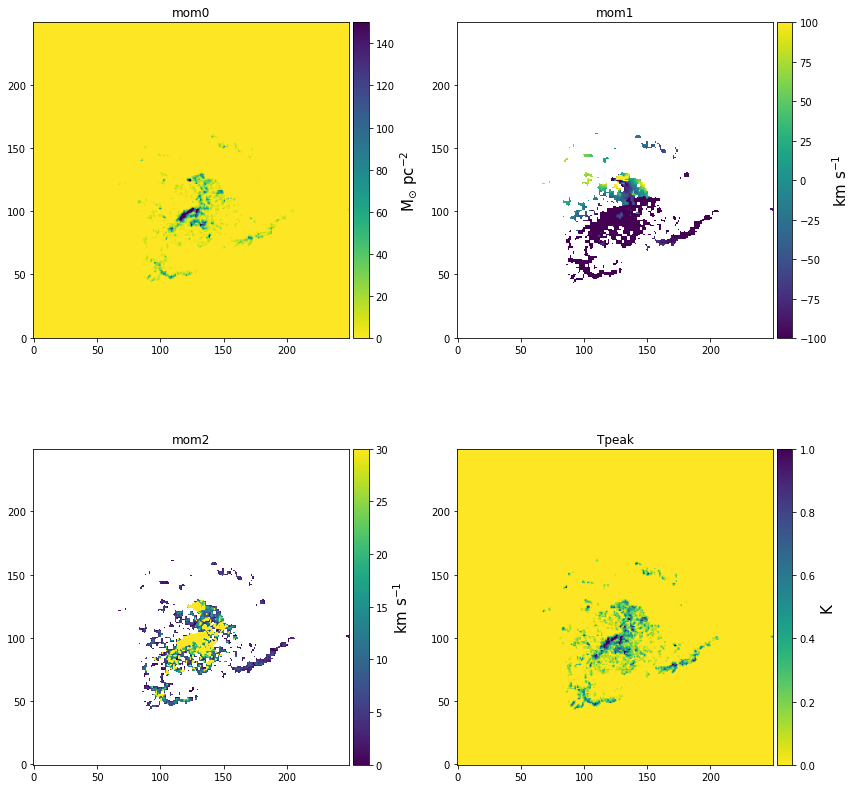

In [46]:
mom0_i3 = np.nansum(data_i3, axis=2)*1e10/100**2
np.min(mom0_i3[np.nonzero(mom0_i3)])

vel = np.arange(-500,500,2)
vel_3d = np.full(np.shape(data_i3),fill_value=np.nan)
vel_3d[:] = vel
mom1_i3 = np.nansum(vel_3d*data_i3,axis=2) / np.nansum(data_i3,axis=2)

mom1_3d_i3 = np.repeat(mom1_i3[:,:,np.newaxis],500,axis=2)
vel_diff = vel_3d - mom1_3d_i3
mom2_i3 = np.sqrt(np.nansum(vel_diff**2*data_i3,axis=2) / np.nansum(data_i3,axis=2))

mom8_i3 = np.nanmax(data_i3, axis=2)*1e10/100**2
Tpeak = mom8_i3 / 4.3 / 2 * 0.7
Tpeak[np.where(np.isnan(Tpeak))] = 0


fig = plt.figure(figsize=(12,12))
ax0 = plt.subplot(221)
ax0.set_title('mom0')
im=ax0.imshow(mom0_i3, origin='lower',vmax=150,cmap='viridis_r')
# insert the colorbar
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cax.set_ylabel('M$_{\odot}$ pc$^{-2}$', fontsize=15)

ax1 = plt.subplot(222)
im=ax1.imshow(mom1_i3, origin='lower',vmax=100,vmin=-100)
ax1.set_title('mom1')
# insert the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cax.set_ylabel('km s$^{-1}$', fontsize=15)

ax2 = plt.subplot(223)
ax2.set_title('mom2')
im = ax2.imshow(mom2_i3, origin='lower', vmax=30)
# insert the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cax.set_ylabel('km s$^{-1}$', fontsize=15)

ax3 = plt.subplot(224)
ax3.set_title('Tpeak')
im = ax3.imshow(Tpeak, origin='lower', vmax=1, cmap='viridis_r')
# insert the colorbar
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cax.set_ylabel('K', fontsize=15)

# adjust the subplot spacing
fig.tight_layout()
np.nanmax(mom0_i3)

#### Load the literature data

In [34]:
filename= 'apjaac326t3_mrt.txt'
skiprows=28
table=pd.read_csv(filename,header=None,sep=r"\s+",skiprows=skiprows,engine='python')
table_120pc=table.loc[(table[1]==120)]
table_main=table_120pc.loc[(table_120pc[0]!='Antennae')]
table_main = table_main.loc[(table_main[0]!='M33')]
table_main = table_main.loc[(table_main[0]!='M31')]
coeffSL_main = table_main[4]**2 / 30

table_antennae = table_120pc.loc[(table_120pc[0]=='Antennae')]
coeffSL_Ant = table_antennae[4]**2 / 30

table_M31 = table_120pc.loc[(table_120pc[0]=='M31')]
table_M33 = table_120pc.loc[(table_120pc[0]=='M33')]
table_M3 = pd.concat([table_M31,table_M33])
coeffSL_M3 = table_M3[4]**2 / 30

Surf_dens = table_main[3]
vel_disp = table_main[4]

Exclude the unbarred galaxy

In [24]:
galaxies = table_main[0]
print(np.unique(galaxies))

table_ubar = table_main[table_main[0].isin(['NGC0628','NGC4254','M51'])]
print(np.unique(table_ubar[0]))
len(table_ubar)

['M51' 'NGC0628' 'NGC1672' 'NGC2835' 'NGC3351' 'NGC3627' 'NGC4254'
 'NGC4303' 'NGC4321' 'NGC4535' 'NGC5068' 'NGC6744']
['M51' 'NGC0628' 'NGC4254']


43877

#### Make the scatter plot between the surface density and the velocity dispersion

0:02:49
None


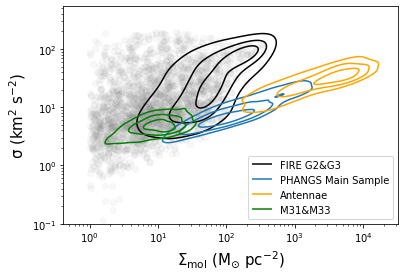

In [50]:
counts_i3 = np.count_nonzero(~np.isnan(data_i3),axis=2)

mom0_i3[np.where(mom0_i3<1)] = np.nan
mom2_i3[np.where(counts_i3<2)] = np.nan

mask = np.ma.mask_or(np.isnan(mom0_i3.flatten()), np.isnan(mom2_i3.flatten()))

# flag the nan values
m1 = mom0_i3.flatten()[np.where(~mask)]
m2 = mom2_i3.flatten()[np.where(~mask)]

# count the time
start = time.time()

fig = plt.figure()
ax = plt.subplot(111)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
plt.ylabel(r'$\sigma$ (km$^2$ s$^{-2}$)',fontsize=15)

# Draw the scatter and contour plot for simulation 
plt.scatter(mom0_i3.flatten(), mom2_i3.flatten(), alpha=0.05, color='gray')
sns.kdeplot(x=m1, y=m2, hue=None,levels=[0.2,0.5,0.8], weights=m1, color='black', label='FIRE G2&G3')
plt.ylim(bottom=0.1)

# Draw the contour plot for literature data
sns.kdeplot(x=Surf_dens, y=vel_disp, hue=None,levels=[0.2,0.5,0.8], weights=Surf_dens, label='PHANGS Main Sample')
sns.kdeplot(x=table_antennae[3], y=table_antennae[4], hue=None,levels=[0.2,0.5,0.8], weights=table_antennae[3], 
            label='Antennae',color='orange')
sns.kdeplot(x=table_M3[3], y=table_M3[4], label='M31&M33', levels=[0.2,0.5,0.8], weights=table_M3[3],
            color='green')
plt.legend(loc='lower right')
plt.savefig('Sigmol_vdep_G2G3_e2_540.pdf', bbox_inches='tight', pad_inches=0.2)

stop = time.time()
print(count_time(stop,start))

#### Plot the size-linewidth relation

Text(0.5, 0, 'Pressure (K km s$^{-1}$)')

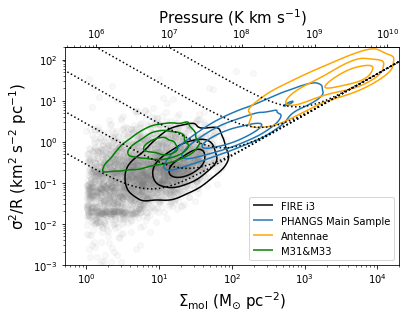

In [7]:
coeffSL_Fire = mom2_i3**2 / 50
m3 = coeffSL_Fire.flatten()[np.where(~mask)]

fig = plt.figure()
ax = plt.subplot(111)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
plt.ylabel(r'$\sigma^2$/R (km$^2$ s$^{-2}$ pc$^{-1}$)',fontsize=15)

# draw the scatter plot
plt.scatter(m1, m3, alpha=0.05, color='gray')
sns.kdeplot(x=m1, y=m3, hue=None,levels=[0.2,0.5,0.8], weights=m1, color='black', label='FIRE i3')

# draw the literature data
sns.kdeplot(x=Surf_dens, y=coeffSL_main, hue=None,levels=[0.2,0.5,0.8], weights=Surf_dens, label='PHANGS Main Sample')
sns.kdeplot(x=table_antennae[3], y=coeffSL_Ant, hue=None,levels=[0.2,0.5,0.8], weights=table_antennae[3], 
            label='Antennae',color='orange')
sns.kdeplot(x=table_M3[3], y=coeffSL_M3, label='M31&M33', levels=[0.2,0.5,0.8], weights=table_M3[3],
            color='green')
plt.legend(loc='lower right')

# set the upper and lower limit
plt.ylim(1e-3, 200)
plt.xlim(0.5, 2e4)

# put in the pressure lines
pressures = 10**np.arange(3, 8, 1)
Sigma_theory = 10**np.arange(-0.5, 5, 0.1)
for p in pressures: 
    ratio = 0.45 * (Sigma_theory/100) + 2.74e-4*p/Sigma_theory
    plt.plot(Sigma_theory, ratio, linestyle='dotted', 
              label="{:.2e}".format(p)+' K cm$^{-3}$', color='black')

# Set upper axis to label the pressure
def Sig2Press(Sig):
    return 200*Sig/2.74e-4
def Press2Sig(p):
    return 2.74e-4*p/200
secax = ax.secondary_xaxis(location='top', functions=(Sig2Press, Press2Sig))
secax.set_xlabel(r'Pressure (K km s$^{-1}$)', fontsize=15)

# save the figure

#### Plot the peak temperature versus velocity dispersion

0:01:47
None


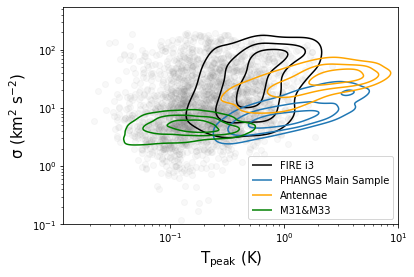

In [41]:
m4 = Tpeak.flatten()[np.where(~mask)]

# count the time
start = time.time()

fig = plt.figure()
ax = plt.subplot(111)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$T_{\mathrm{peak}}$ (K)',fontsize=15)
plt.ylabel(r'$\sigma$ (km$^2$ s$^{-2}$)',fontsize=15)

# Draw the scatter and contour plot for simulation 
plt.scatter(m4, m2, alpha=0.05, color='gray')
sns.kdeplot(x=m4, y=m2, hue=None,levels=[0.2,0.5,0.8], weights=m1, color='black', label='FIRE i3')
plt.ylim(bottom=0.1)
plt.xlim(right=10)

# Draw the contour plot for literature data
sns.kdeplot(x=table_main[2], y=table_main[4], hue=None,levels=[0.2,0.5,0.8], weights=table_main[3], label='PHANGS Main Sample')
sns.kdeplot(x=table_antennae[2], y=table_antennae[4], hue=None,levels=[0.2,0.5,0.8], weights=table_antennae[3], 
            label='Antennae',color='orange')
sns.kdeplot(x=table_M3[2], y=table_M3[4], label='M31&M33', levels=[0.2,0.5,0.8], weights=table_M3[3],
            color='green')
plt.legend(loc='lower right')
plt.savefig('Tpeak_vdep_i3.pdf', bbox_inches='tight', pad_inches=0.2)

stop = time.time()
print(count_time(stop,start))

#### Exclude the unbarred galaxy and Antennae

Velocity dipserion versus surface density

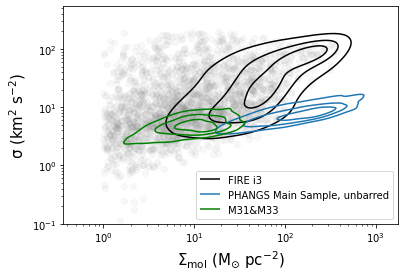

In [40]:
## Velocity dispersion versus surface density
fig = plt.figure()
ax = plt.subplot(111)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
plt.ylabel(r'$\sigma$ (km$^2$ s$^{-2}$)',fontsize=15)

# Draw the scatter and contour plot for simulation 
plt.scatter(mom0_i3.flatten(), mom2_i3.flatten(), alpha=0.05, color='gray')
sns.kdeplot(x=m1, y=m2, hue=None,levels=[0.2,0.5,0.8], weights=m1, color='black', label='FIRE i3')
plt.ylim(bottom=0.1)

# Draw the contour plot for literature data
sns.kdeplot(x=table_ubar[3], y=table_ubar[4], hue=None,levels=[0.2,0.5,0.8], weights=table_ubar[3], label='PHANGS Main Sample, unbarred')
sns.kdeplot(x=table_M3[3], y=table_M3[4], label='M31&M33', levels=[0.2,0.5,0.8], weights=table_M3[3],
            color='green')
plt.legend(loc='lower right')
plt.savefig('Sigmol_vdep_i3_unbarred.pdf', bbox_inches='tight',pad_inches=0.2)

In [10]:
print(np.nanmax(table_ubar[3]))

1030.0


Plot the velocity dispersion versus peak brightness temperature

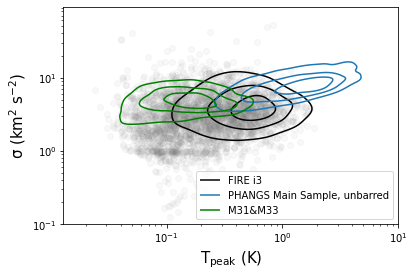

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$T_{\mathrm{peak}}$ (K)',fontsize=15)
plt.ylabel(r'$\sigma$ (km$^2$ s$^{-2}$)',fontsize=15)

# Draw the scatter and contour plot for simulation 
plt.scatter(m4, m2, alpha=0.05, color='gray')
sns.kdeplot(x=m4, y=m2, hue=None,levels=[0.2,0.5,0.8], weights=m1, color='black', label='FIRE i3')
plt.ylim(bottom=0.1)
plt.xlim(right=10)

# Draw the contour plot for literature data
sns.kdeplot(x=table_ubar[2], y=table_ubar[4], hue=None,levels=[0.2,0.5,0.8], weights=table_ubar[3], label='PHANGS Main Sample, unbarred')
sns.kdeplot(x=table_M3[2], y=table_M3[4], label='M31&M33', levels=[0.2,0.5,0.8], weights=table_M3[3], color='green')
plt.legend(loc='lower right')
plt.savefig('Tpeak_vdep_i3_unbarred.pdf',bbox_inches='tight',pad_inches=0.2)